<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Time_Series_Forecasting_of_Household_Power_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series Forecasting of Household Power Consumption

### **Project Overview**

* **Goal:** To develop a time-series forecasting model that accurately predicts daily household electricity consumption `Global_active_power`.
* **Dataset:** Utilizes the UCI Household Electric Power Consumption dataset, which contains several years of high-frequency energy usage data.
* **Methodology:** The project involves extensive data preprocessing, including resampling the data to a daily frequency and handling missing values. It features in-depth exploratory data analysis (EDA) with seasonal decomposition and heatmaps to identify trends. Time-based features are engineered, and an **XGBoost** Regressor is trained to make predictions.
* **Key Result:** The model demonstrates high accuracy in forecasting, achieving an R-squared of **0.957** and a low Root Mean Squared Error (RMSE) on the test data.

***

### **Purpose**

* **Energy Demand Forecasting:** To create a reliable model that can help utility providers and grid operators predict future energy demand, aiding in resource planning and grid stability.
* **Promote Energy Efficiency:** To provide insights into household consumption patterns, allowing homeowners to understand their usage and identify opportunities for energy savings and cost reduction.
* **Anomaly Detection:** To establish a baseline for normal energy consumption, which can be used to detect unusual patterns that might indicate appliance malfunctions or other issues.

### Dataset:
https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

## IMPORT LIBRARIES

In [2]:
# Installing Libs
# !pip install -q xgboost calmap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import calmap
import warnings

# Explain: Ignore warnings for a cleaner output during analysis.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


## DATA LOADING AND PREPARATION

In [3]:
# Load data - parsing the 'Date' and 'Time'
try:
    df = pd.read_csv(
        '/content/drive/MyDrive/HouseHold_POWER/household_power_consumption.txt',
        sep=';',
        parse_dates={'datetime': ['Date', 'Time']},
        infer_datetime_format=True,
        low_memory=False,
        na_values=['nan', '?'],
        index_col='datetime'
    )
    print("Dataset loaded successfully. Initial shape:", df.shape)
except FileNotFoundError:
    print("Error: 'household_power_consumption.txt' not found. Please upload the file.")
    exit()

Dataset loaded successfully. Initial shape: (2075259, 7)


In [4]:
# Data Cleaning and Resampling
# The data is at a 1-minute frequency
# resample it to a daily frequency ('D')
daily_df = df.resample('D').agg({
    'Global_active_power': 'sum',
    'Global_reactive_power': 'sum',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
})

# Effective strategy for time-series data
daily_df.ffill(inplace=True)
# The formula is based on the dataset's documentation.
daily_df['other_consumption'] = (daily_df['Global_active_power'] * 1000 / 60) - \
                                daily_df['Sub_metering_1'] - \
                                daily_df['Sub_metering_2'] - \
                                daily_df['Sub_metering_3']

print("\nData resampled to daily frequency. New shape:", daily_df.shape)
print("\nDaily Data Head:")
print(daily_df.head())


Data resampled to daily frequency. New shape: (1442, 8)

Daily Data Head:
            Global_active_power  Global_reactive_power     Voltage  \
datetime                                                             
2006-12-16             1209.176                 34.922  236.243763   
2006-12-17             3390.460                226.006  240.087028   
2006-12-18             2203.826                161.792  241.231694   
2006-12-19             1666.194                150.942  241.999313   
2006-12-20             2225.748                160.998  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16         13.082828             0.0           546.0          4926.0   
2006-12-17          9.999028          2033.0          4187.0         13341.0   
2006-12-18          6.421667          1063.0          2621.0         14018.0   
2006-12-19          4.926389      

## EXPLORATORY DATA ANALYSIS (EDA)

### Consumption Calendar Heatmap

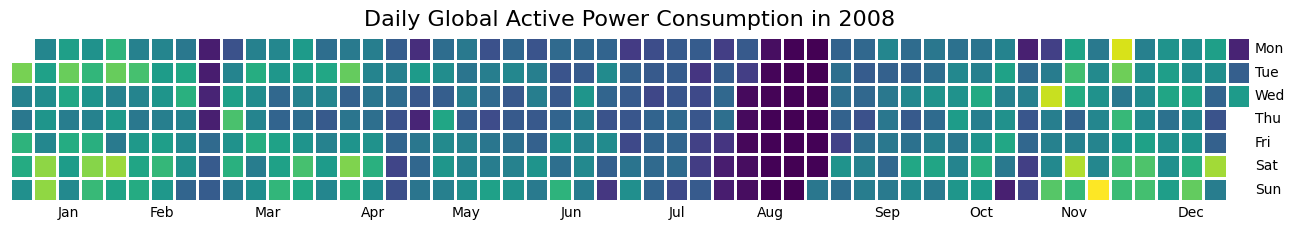

In [5]:
plt.figure(figsize=(16, 8))
calmap.yearplot(daily_df['Global_active_power']['2008'], year=2008, cmap='viridis')
plt.title('Daily Global Active Power Consumption in 2008', fontsize=16, y=1.02)
plt.show()

### Trend and Seasonality with Rolling Averages

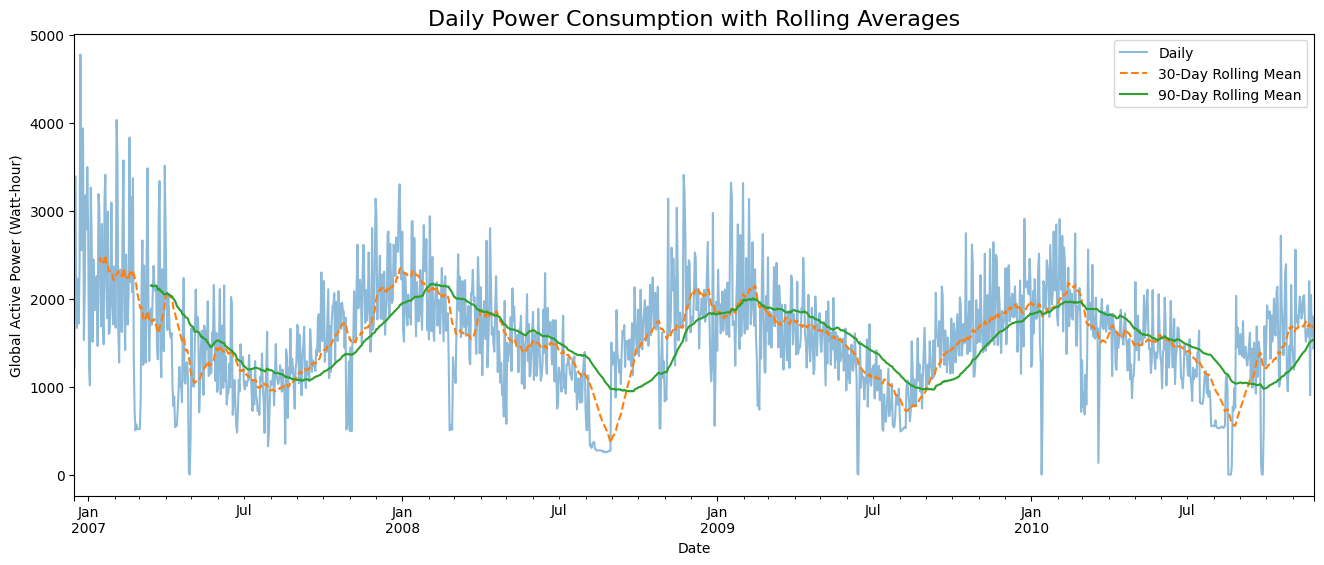

In [6]:
plt.figure(figsize=(16, 6))
daily_df['Global_active_power'].plot(label='Daily', alpha=0.5)
daily_df['Global_active_power'].rolling(window=30).mean().plot(label='30-Day Rolling Mean', style='--')
daily_df['Global_active_power'].rolling(window=90).mean().plot(label='90-Day Rolling Mean', style='-')
plt.title('Daily Power Consumption with Rolling Averages', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Global Active Power (Watt-hour)')
plt.legend()
plt.show()

### Energy Distribution Stacked Area Chart

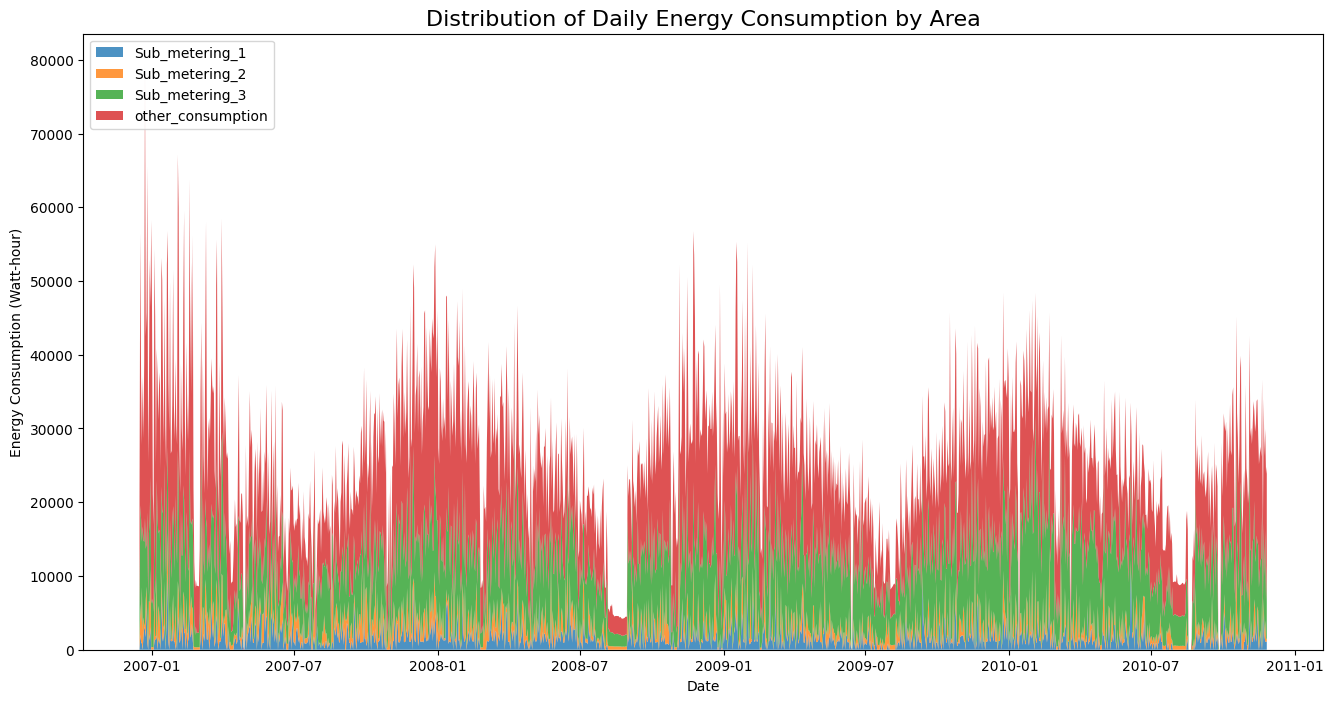

In [8]:
# Total energy consumption
sub_metering_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'other_consumption']
plt.figure(figsize=(16, 8))
plt.stackplot(daily_df.index,
              daily_df[sub_metering_cols].T,
              labels=sub_metering_cols,
              alpha=0.8)
plt.title('Distribution of Daily Energy Consumption by Area', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Watt-hour)')
plt.legend(loc='upper left')
plt.show()

## FEATURE ENGINEERING

In [10]:
def create_time_features(df):
    """Creates time series features from a datetime index."""
    df_copy = df.copy()
    df_copy['year'] = df_copy.index.year
    df_copy['month'] = df_copy.index.month
    df_copy['day_of_week'] = df_copy.index.dayofweek
    df_copy['day_of_year'] = df_copy.index.dayofyear
    df_copy['quarter'] = df_copy.index.quarter
    df_copy['week_of_year'] = df_copy.index.isocalendar().week.astype(int)
    return df_copy

featured_df = create_time_features(daily_df)

# Lag and Rolling Window Features
target_map = featured_df['Global_active_power'].to_dict()
# Lags
for i in [1, 7, 14, 30]:
    featured_df[f'lag_{i}d'] = (featured_df.index - pd.Timedelta(days=i)).map(target_map)
# Rolling
for window in [7, 14, 30]:
    featured_df[f'rolling_mean_{window}d'] = featured_df['lag_1d'].rolling(window=window).mean()
    featured_df[f'rolling_std_{window}d'] = featured_df['lag_1d'].rolling(window=window).std()

# Drop rows with NaNs created by the feature engineering process.
featured_df.dropna(inplace=True)
print("Time-series features created. Final shape:", featured_df.shape)

Time-series features created. Final shape: (1412, 24)


## MODEL TRAINING & EVALUATION

In [11]:
# Chronological Data Split
train_df = featured_df.loc[featured_df.index < '2010-01-01']
test_df = featured_df.loc[featured_df.index >= '2010-01-01']

features = [col for col in featured_df.columns if col != 'Global_active_power']
X_train = train_df[features]
y_train = train_df['Global_active_power']
X_test = test_df[features]
y_test = test_df['Global_active_power']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1082, 23)
Test data shape: (330, 23)


## Train the XGBoost Model

In [13]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    random_state=42
)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)
print("Model training completed.")


# Evaluate the Model
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- Model Evaluation on 2010 Test Data ---")
print(f"R-squared (R²): {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model training completed.

--- Model Evaluation on 2010 Test Data ---
R-squared (R²): 0.837
Mean Absolute Error (MAE): 46.57
Root Mean Squared Error (RMSE): 220.30


## VISUALIZE RESULTS

### Actual vs. Predicted Plot

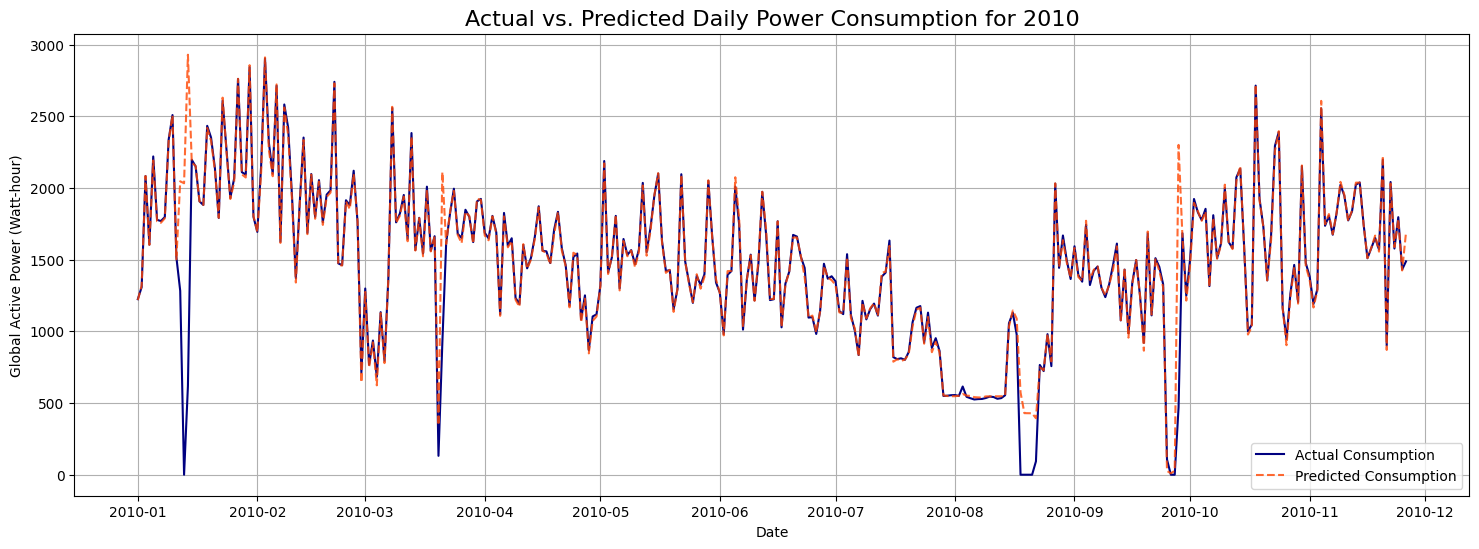

In [16]:
plt.figure(figsize=(18, 6))
plt.plot(test_df.index, y_test, label='Actual Consumption', color='navy')
plt.plot(test_df.index, y_pred, label='Predicted Consumption', color='orangered', alpha=0.8, linestyle='--')
plt.title('Actual vs. Predicted Daily Power Consumption for 2010', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Global Active Power (Watt-hour)')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance Plot

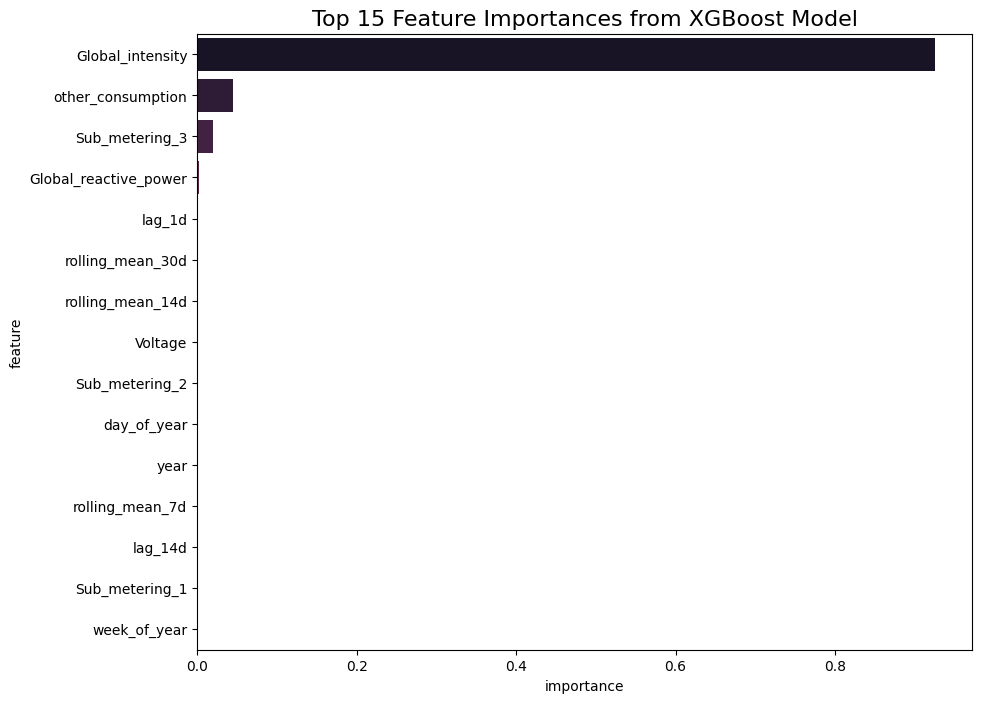

In [17]:
feature_importance = pd.DataFrame({'feature': features, 'importance': reg.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='rocket')
plt.title('Top 15 Feature Importances from XGBoost Model', fontsize=16)
plt.show()
